In [1]:
import os
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, TimeDistributed

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dir_path = '/content/drive/MyDrive/FD004/'
train_file = 'train_FD004.txt'
test_file = 'test_FD004.txt'
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names
train = pd.read_csv((dir_path+train_file), sep='\s+', header=None,
                 names=col_names)
test = pd.read_csv((dir_path+test_file), sep='\s+', header=None,
                 names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD004.txt'), sep='\s+', header=None,
                 names=['RemainingUsefulLife'])

print(train.shape)
train.head()

(61249, 26)


,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754


In [4]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()

    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)

    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life

    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

,unit_nr,time_cycles,RUL
0,1,1,320
1,1,2,319
2,1,3,318
3,1,4,317
4,1,5,316


In [5]:
X_train = train[setting_names + sensor_names].copy()
y_train = train['RUL'].copy()
y_train_clipped = y_train.clip(upper=125)

# get last row of each engine
X_test = test.drop('time_cycles', axis=1).groupby('unit_nr').last().copy()

In [6]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [7]:
lm = LinearRegression()
lm.fit(X_train, y_train)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:60.28599555343593, R2:0.549133495468477
test set RMSE:47.75764832870611, R2:0.2327909053988798


In [8]:
def add_operating_condition(df):
    df_op_cond = df.copy()

    df_op_cond['setting_1'] = df_op_cond['setting_1'].round()
    df_op_cond['setting_2'] = df_op_cond['setting_2'].round(decimals=2)

    # converting settings to string and concatanating makes the operating condition into a categorical variable
    df_op_cond['op_cond'] = df_op_cond['setting_1'].astype(str) + '_' + \
                        df_op_cond['setting_2'].astype(str) + '_' + \
                        df_op_cond['setting_3'].astype(str)

    return df_op_cond

def condition_scaler(df_train, df_test, sensor_names):
    # apply operating condition specific scaling
    scaler = StandardScaler()
    for condition in df_train['op_cond'].unique():
        scaler.fit(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
    return df_train, df_test

X_train_condition = add_operating_condition(train)
X_test_condition = add_operating_condition(X_test)

X_train_condition_scaled, X_test_condition_scaled = condition_scaler(X_train_condition, X_test_condition, sensor_names)

<ipython-input-8-9db9cef19cfd>:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
<ipython-input-8-9db9cef19cfd>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.27462144 -0.32737159 -0.92936463  1.47860752 -0.92936463 -0.92936463
  0.27462144  0.87661448 -0.32737159  0.87661448 -2.73534374  1.47860752
 -0.92936463  0.87661448 -1.53135767  0.87661448 -0.92936463  0.87661448
 -0.92936463 -0.32737159 -0.92936463  1.47860752  0.27462144  1.47860752
  0.27462144  0.87661448 -0.92936463  0.87661448  0.27462144  2.08060055


In [9]:
def plot_signal(df, signal_name, unit_nr=None):
    plt.figure(figsize=(13,5))

    if unit_nr:
        plt.plot('RUL', signal_name,
                data=df[df['unit_nr']==unit_nr])
    else:
        for i in train['unit_nr'].unique():
            if (i % 10 == 0):  # only ploting every 10th unit_nr
                plt.plot('RUL', signal_name,
                         data=df[df['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(signal_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

for sensor in sensor_names:
  plot_signal(X_train_condition_scaled, sensor)

Output hidden; open in https://colab.research.google.com to view.

In [10]:
remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

print(drop_sensors)

['s_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']


In [11]:
def exponential_smoothing(df, sensors, n_samples, alpha=0.4):
    df = df.copy()
    # first, calculate the exponential weighted mean of desired sensors
    # Reset index before applying ewm
    df[sensors] = df.groupby('unit_nr')[sensors].apply(lambda x: x.reset_index(drop=True).ewm(alpha=alpha).mean()).values
    # Reset index after applying ewm to match original dataframe
    df.reset_index(drop=True, inplace=True)

    # second, drop first n_samples of each unit_nr to reduce filter delay
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result

    mask = df.groupby('unit_nr')['unit_nr'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]

    return df

In [12]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)  # eventhough we set np and tf seeds, gss requires its own seed

def train_val_group_split(X, y, gss, groups, print_groups=True):

    for idx_train, idx_val in gss.split(X, y, groups=groups):
        if print_groups:
            print('train_split_engines', train.iloc[idx_train]['unit_nr'].unique())
            print('validate_split_engines', train.iloc[idx_val]['unit_nr'].unique(), '\n')

        X_train_split = X.iloc[idx_train].copy()
        y_train_split = y.iloc[idx_train].copy()
        X_val_split = X.iloc[idx_val].copy()
        y_val_split = y.iloc[idx_val].copy()
    return X_train_split, y_train_split, X_val_split, y_val_split

In [13]:
def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]

    # -1 and +1 because of Python indexing
    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]


In [14]:
def gen_data_wrapper(df, sequence_length, columns, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()

    data_gen = (list(gen_train_data(df[df['unit_nr']==unit_nr], sequence_length, columns))
               for unit_nr in unit_nrs)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array



In [15]:
def gen_labels(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    # -1 because I want to predict the rul of that last row in the sequence, not the next row
    return data_matrix[sequence_length-1:num_elements, :]

def gen_label_wrapper(df, sequence_length, label, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()

    label_gen = [gen_labels(df[df['unit_nr']==unit_nr], sequence_length, label)
                for unit_nr in unit_nrs]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array

In [16]:
def gen_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) # pad
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:,:] = df[columns].values  # fill with available data
    else:
        data_matrix = df[columns].values

    # specifically yield the last possible sequence
    stop = num_elements = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :]

In [17]:
sequence_length = 20
train['RUL'].clip(upper=125, inplace=True)

X_train_interim = add_operating_condition(train.drop(drop_sensors, axis=1))
X_test_interim = add_operating_condition(test.drop(drop_sensors, axis=1))

X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)

X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, 0, 0.4)
X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, 0, 0.4)

# train-val split
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)
for train_unit, val_unit in gss.split(X_train_interim['unit_nr'].unique(), groups=X_train_interim['unit_nr'].unique()):
    train_unit = X_train_interim['unit_nr'].unique()[train_unit]  # gss returns indexes and index starts at 1
    val_unit = X_train_interim['unit_nr'].unique()[val_unit]

    train_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
    train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], train_unit)

    val_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
    val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], val_unit)

# create sequences train, test
train_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

test_gen = (list(gen_test_data(X_test_interim[X_test_interim['unit_nr']==unit_nr], sequence_length, remaining_sensors, -99.))
           for unit_nr in X_test_interim['unit_nr'].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)

<ipython-input-17-26d1ac457b81>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['RUL'].clip(upper=125, inplace=True)
<ipython-input-8-9db9cef19cfd>:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transfo

In [18]:
model = Sequential()
model.add(Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
model.add(LSTM(32, activation='tanh'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('simple_lstm.weights.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
model.compile(loss='mean_squared_error', optimizer='adam')  # the model is recompiled to reset the optimizer
model.load_weights('simple_lstm.weights.h5')  # weights are reloaded to ensure reproducible results

history = model.fit(train_split_array, train_split_label,
                    validation_data=(val_split_array, val_split_label),
                    epochs=5,
                   batch_size=32)

Epoch 1/5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - loss: 7146.3374 - val_loss: 3111.5798
Epoch 2/5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 2478.9641 - val_loss: 1096.9991
Epoch 3/5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 836.7952 - val_loss: 493.0666
Epoch 4/5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - loss: 357.6287 - val_loss: 390.1909
Epoch 5/5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - loss: 254.9590 - val_loss: 370.0927


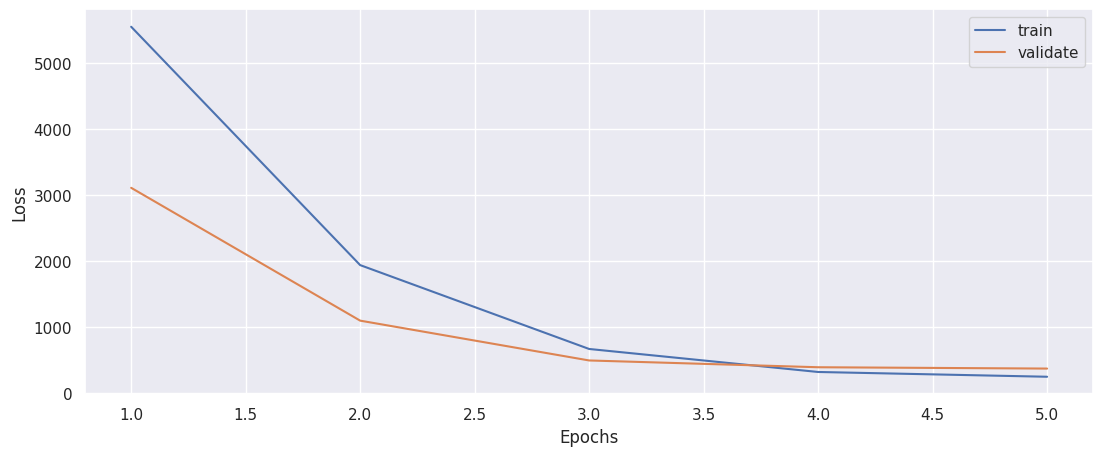

In [20]:
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [21]:
y_hat_train = model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
evaluate(y_test, y_hat_test)

1767/1767 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
train set RMSE:15.980423395040747, R2:0.8497256636619568
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
test set RMSE:28.84636639169492, R2:0.7200953960418701


In [22]:
alpha_list = [0.01, 0.05] + list(np.arange(10,60+1,10)/100)

sequence_list = list(np.arange(10,40+1,5))
epoch_list = list(np.arange(5,20+1,5))
nodes_list = [[32], [64], [128], [256], [32, 64], [64, 128], [128, 256]]

# lowest dropout=0.1, because I know zero dropout will yield better training results but worse generalization
dropouts = list(np.arange(1,5)/10)

activation_functions = ['tanh', 'sigmoid']
batch_size_list = [32, 64, 128, 256]
sensor_list = [['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21'],
               ['s_2', 's_3', 's_4', 's_7', 's_11', 's_12', 's_15', 's_17', 's_20', 's_21']]

tuning_options = np.prod([len(alpha_list),
                          len(sequence_list),
                          len(epoch_list),
                          len(nodes_list),
                          len(dropouts),
                          len(activation_functions),
                          len(batch_size_list),
                          len(sensor_list)])
tuning_options

np.int64(100352)

In [23]:
def prep_data(train, test, drop_sensors, remaining_sensors, alpha):
    X_train_interim = add_operating_condition(train.drop(drop_sensors, axis=1))
    X_test_interim = add_operating_condition(test.drop(drop_sensors, axis=1))

    X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)

    X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, 0, alpha)
    X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, 0, alpha)

    return X_train_interim, X_test_interim

In [24]:
def create_model(input_shape, nodes_per_layer, dropout, activation, weights_file):
    model = Sequential()
    model.add(Masking(mask_value=-99., input_shape=input_shape))
    if len(nodes_per_layer) <= 1:
        model.add(LSTM(nodes_per_layer[0], activation=activation))
        model.add(Dropout(dropout))
    else:
        model.add(LSTM(nodes_per_layer[0], activation=activation, return_sequences=True))
        model.add(Dropout(dropout))
        model.add(LSTM(nodes_per_layer[1], activation=activation))
        model.add(Dropout(dropout))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.save_weights(weights_file)
    return model

In [25]:
remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

In [26]:
# ITERATIONS = 60

# results = pd.DataFrame(columns=['MSE', 'std_MSE', 'alpha', # bigger std means less robust
#                                 'epochs', 'nodes', 'dropout',
#                                 'activation', 'batch_size',
#                                 'sequence_length', 'sensor_length'])

# weights_file = 'lstm_hyper_parameter_weights.h5'


# for i in range(ITERATIONS):
#     if ITERATIONS < 10:
#         print('iteration ', i+1)
#     elif ((i+1) % 10 == 0):
#         print('iteration ', i+1)

#     mse = []

#     # init parameters
#     alpha = random.sample(alpha_list, 1)[0]
#     sequence_length = random.sample(sequence_list, 1)[0]
#     epochs = random.sample(epoch_list, 1)[0]
#     nodes_per_layer = random.sample(nodes_list, 1)[0]
#     dropout = random.sample(dropouts, 1)[0]
#     activation = random.sample(activation_functions, 1)[0]
#     batch_size = random.sample(batch_size_list, 1)[0]
#     remaining_sensors = random.sample(sensor_list, 1)[0]
#     drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

#     # create model
#     input_shape = (sequence_length, len(remaining_sensors))
#     model = create_model(input_shape, nodes_per_layer, dropout, activation, weights_file)

#     # create train-val split
#     X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)
#     gss = GroupShuffleSplit(n_splits=3, train_size=0.80, random_state=42)
#     for train_unit, val_unit in gss.split(X_train_interim['unit_nr'].unique(), groups=X_train_interim['unit_nr'].unique()):
#         train_unit = X_train_interim['unit_nr'].unique()[train_unit]  # gss returns indexes and index starts at 1
#         train_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
#         train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], train_unit)

#         val_unit = X_train_interim['unit_nr'].unique()[val_unit]
#         val_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
#         val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], val_unit)

#         # train and evaluate model
#         model.compile(loss='mean_squared_error', optimizer='adam')
#         model.load_weights(weights_file)  # reset optimizer and node weights before every training iteration

#         history = model.fit(train_split_array, train_split_label,
#                             validation_data=(val_split_array, val_split_label),
#                             epochs=epochs,
#                             batch_size=batch_size,
#                             verbose=0)
#         mse.append(history.history['val_loss'][-1])

#     # append results
#     d = {'MSE':np.mean(mse), 'std_MSE':np.std(mse), 'alpha':alpha,
#          'epochs':epochs, 'nodes':str(nodes_per_layer), 'dropout':dropout,
#          'activation':activation, 'batch_size':batch_size, 'sequence_length':sequence_length,
#          'sensor_length':len(remaining_sensors)}
#     results = results.append(pd.DataFrame(d, index=[0]), ignore_index=True)

In [27]:
alpha = 0.1
sequence_length = 30
nodes_per_layer = [256]
dropout = 0.1
activation = 'sigmoid'
weights_file = 'fd004_model.weights.h5'
epochs = 15
batch_size = 128

# prep data
X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)

train_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

test_gen = (list(gen_test_data(X_test_interim[X_test_interim['unit_nr']==unit_nr], sequence_length, remaining_sensors, -99.))
           for unit_nr in X_test_interim['unit_nr'].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)

input_shape = (sequence_length, len(remaining_sensors))
final_model = create_model(input_shape, nodes_per_layer, dropout, activation, weights_file)

final_model.compile(loss='mean_squared_error', optimizer='adam')
final_model.load_weights(weights_file)

final_model.fit(train_array, label_array,
                epochs=epochs,
                batch_size=batch_size)

<ipython-input-8-9db9cef19cfd>:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
<ipython-input-8-9db9cef19cfd>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448  0.87661448
  0.27462144]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/

Epoch 1/15
423/423 ━━━━━━━━━━━━━━━━━━━━ 126s 291ms/step - loss: 6095.7451
Epoch 2/15
423/423 ━━━━━━━━━━━━━━━━━━━━ 123s 246ms/step - loss: 1919.1843
Epoch 3/15
423/423 ━━━━━━━━━━━━━━━━━━━━ 104s 245ms/step - loss: 578.1420
Epoch 4/15
423/423 ━━━━━━━━━━━━━━━━━━━━ 144s 250ms/step - loss: 348.2352
Epoch 5/15
423/423 ━━━━━━━━━━━━━━━━━━━━ 106s 249ms/step - loss: 256.2260
Epoch 6/15
423/423 ━━━━━━━━━━━━━━━━━━━━ 107s 254ms/step - loss: 223.4003
Epoch 7/15
423/423 ━━━━━━━━━━━━━━━━━━━━ 141s 252ms/step - loss: 208.1974
Epoch 8/15
423/423 ━━━━━━━━━━━━━━━━━━━━ 142s 253ms/step - loss: 197.1904
Epoch 9/15
423/423 ━━━━━━━━━━━━━━━━━━━━ 106s 249ms/step - loss: 190.5071
Epoch 10/15
423/423 ━━━━━━━━━━━━━━━━━━━━ 141s 246ms/step - loss: 186.2367
Epoch 11/15
423/423 ━━━━━━━━━━━━━━━━━━━━ 141s 244ms/step - loss: 182.1339
Epoch 12/15
423/423 ━━━━━━━━━━━━━━━━━━━━ 104s 246ms/step - loss: 177.4643
Epoch 13/15
423/423 ━━━━━━━━━━━━━━━━━━━━ 142s 247ms/step - loss: 173.7143
Epoch 14/15
423/423 ━━━━━━━━━━━━━━━━━━━━ 141s

In [28]:
y_hat_train = model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
evaluate(y_test, y_hat_test)

1689/1689 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step
train set RMSE:21.660158715622043, R2:0.7273328900337219
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
test set RMSE:34.04547847353871, R2:0.6101058125495911


y_test type: <class 'pandas.core.frame.DataFrame'>
y_test shape: (248, 1)
y_test columns: Index(['RemainingUsefulLife'], dtype='object')
y_test head:
    RemainingUsefulLife
0                   22
1                   39
2                  107
3                   75
4                  149


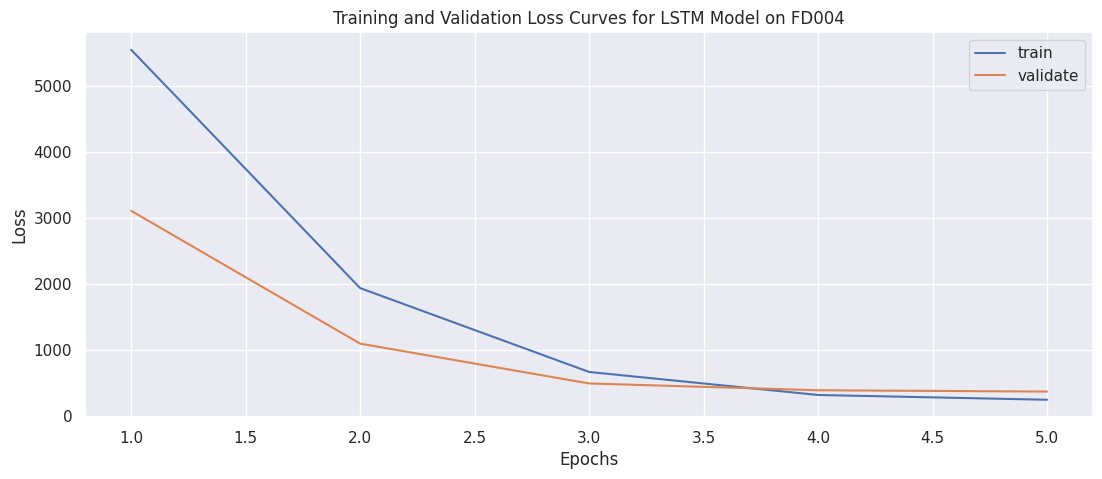

NameError: name 'y_train_values' is not defined

<Figure size 800x800 with 0 Axes>

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Handle y_test as DataFrame or Series
if isinstance(y_test, pd.DataFrame):
    try:
        y_test_values = y_test['RUL'].values  # Try accessing 'RUL' column
    except KeyError:
        y_test_values = y_test.iloc[:, 0].values  # Use first column if 'RUL' is missing
elif isinstance(y_test, pd.Series):
    y_test_values = y_test.values  # Direct values for Series
else:
    raise ValueError("y_test must be a pandas DataFrame or Series")

# Debug y_test structure
print("y_test type:", type(y_test))
print("y_test shape:", y_test.shape)
print("y_test columns:", y_test.columns if isinstance(y_test, pd.DataFrame) else "No columns (Series)")
print("y_test head:\n", y_test.head())

# 1. Figure G.18: Training and Validation Loss Curves for LSTM Model
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves for LSTM Model on FD004')
    plt.legend()
    plt.show()

plot_loss(history)

plt.figure(figsize=(8,8))
plt.scatter(y_train_values, y_hat_train, label='Training Data', alpha=0.5, color='blue')  # Blue to distinguish from test (orange)
plt.plot([0, max(y_train_values.max(), y_hat_train.max())],
         [0, max(y_train_values.max(), y_hat_train.max())], 'r--', label='Perfect Prediction')
plt.grid(True)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs. Predicted RUL for LSTM on FD004 Training Data')
plt.legend()
plt.show()

# 2. Figure G.19: Actual vs. Predicted RUL for LSTM on FD004 Test Data
plt.figure(figsize=(8,8))
plt.scatter(y_test_values, y_hat_test, label='Test Data', alpha=0.5, color='orange')
plt.plot([0, max(y_test_values.max(), y_hat_test.max())], [0, max(y_test_values.max(), y_hat_test.max())], 'r--', label='Perfect Prediction')
plt.grid(True)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs. Predicted RUL for LSTM on FD004 Test Data')
plt.legend()
plt.show()

# 3. Figure G.20: Histogram of Clipped RUL for FD004 Training Data
plt.figure(figsize=(13,5))
y_train_clipped.hist(bins=15)
plt.xlabel('Remaining Useful Life (RUL)')
plt.ylabel('Frequency')
plt.title('Histogram of Clipped RUL for FD004 Training Data')
plt.show()

# 4. Figure G.21: Time-Series Plot of Sensor s_2 for Selected Engines
def plot_signal(df, signal_name, unit_nr=None):
    plt.figure(figsize=(13,5))
    if unit_nr:
        plt.plot('RUL', signal_name, data=df[df['unit_nr']==unit_nr])
    else:
        for i in df['unit_nr'].unique():
            if (i % 10 == 0):
                plt.plot('RUL', signal_name, data=df[df['unit_nr']==i])
    plt.xlim(250, 0)
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(signal_name)
    plt.xlabel('Remaining Useful Life')
    plt.title(f'Time-Series Plot of Sensor {signal_name} for Selected Engines in FD004')
    plt.show()

plot_signal(X_train_condition_scaled, 's_2')

# 5. Figure G.22: Sensor s_2 Readings Across Operating Conditions
plt.figure(figsize=(13,5))
op_cond = X_train_condition['op_cond'].unique()
for condition in op_cond:
    data = X_train_condition.loc[X_train_condition['op_cond']==condition]
    plt.plot(data['RUL'], data['s_2'], '.', label=f'Condition {condition}')
plt.xlim(250, 0)
plt.xlabel('Remaining Useful Life (RUL)')
plt.ylabel('Sensor s_2 Reading')
plt.title('Sensor s_2 Readings Across Operating Conditions in FD004')
plt.legend()
plt.show()

# 6. Figure G.23: Actual vs. Predicted RUL for Linear Regression on Training Data
y_hat_train_lr = lm.predict(X_train)  # Linear Regression predictions
plt.figure(figsize=(8,8))
plt.scatter(y_train, y_hat_train_lr, label='Train Data', alpha=0.5, color='blue')
plt.plot([0, y_train.max()], [0, y_train.max()], 'r--', label='Perfect Prediction')
plt.grid(True)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs. Predicted RUL for Linear Regression on FD004 Training Data')
plt.legend()
plt.show()

# 7. Figure G.24: Actual vs. Predicted RUL for Linear Regression on Test Data
y_hat_test_lr = lm.predict(X_test)  # Linear Regression predictions
plt.figure(figsize=(8,8))
plt.scatter(y_test_values, y_hat_test_lr, label='Test Data', alpha=0.5, color='orange')
plt.plot([0, max(y_test_values.max(), y_hat_test_lr.max())], [0, max(y_test_values.max(), y_hat_test_lr.max())], 'r--', label='Perfect Prediction')
plt.grid(True)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs. Predicted RUL for Linear Regression on FD004 Test Data')
plt.legend()
plt.show()

# 8. Figure G.25: Effect of Alpha on LSTM Validation MSE
plt.figure(figsize=(13,5))
plt.scatter(results['alpha'], results['MSE'], alpha=0.5)
plt.xlabel('Alpha (Exponential Smoothing)')
plt.ylabel('Validation MSE')
plt.title('Effect of Alpha on LSTM Validation MSE for FD004')
plt.grid(True)
plt.show()

final_model defined: True
train_array defined: True
label_array defined: True
train_array shape: (54028, 30, 14)
label_array shape: (54028, 1)
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 59s 34ms/step
y_train_values shape: (54028,)
y_hat_train shape: (54028,)


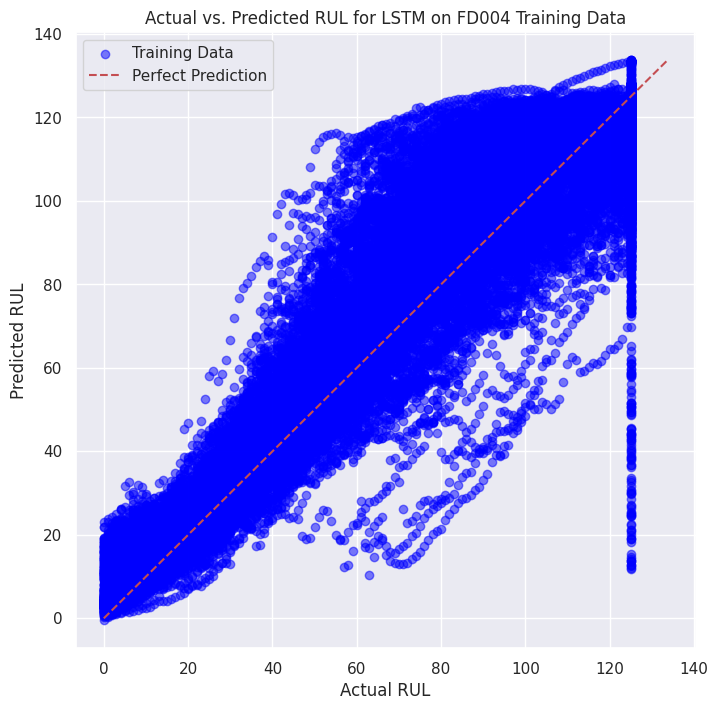

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Debug variable availability
print("final_model defined:", 'final_model' in globals())
print("train_array defined:", 'train_array' in globals())
print("label_array defined:", 'label_array' in globals())
print("train_array shape:", train_array.shape if 'train_array' in globals() else "Not defined")
print("label_array shape:", label_array.shape if 'label_array' in globals() else "Not defined")

# Generate predictions for training data
try:
    y_hat_train = final_model.predict(train_array)  # Predict RUL for training data
    y_hat_train = y_hat_train.flatten()            # Flatten to 1D array
except NameError as e:
    raise NameError("Required variables (final_model or train_array) are not defined. Ensure LSTM training is complete.")

# Define actual RUL for training data
try:
    y_train_values = label_array.flatten()         # Flatten label_array to 1D array
except NameError as e:
    raise NameError("label_array is not defined. Ensure gen_label_wrapper was run.")

# Debug shapes
print("y_train_values shape:", y_train_values.shape)
print("y_hat_train shape:", y_hat_train.shape)

# Figure G.26: Actual vs. Predicted RUL for LSTM on FD004 Training Data
plt.figure(figsize=(8,8))
plt.scatter(y_train_values, y_hat_train, label='Training Data', alpha=0.5, color='blue')  # Blue to distinguish from test
plt.plot([0, max(y_train_values.max(), y_hat_train.max())],
         [0, max(y_train_values.max(), y_hat_train.max())], 'r--', label='Perfect Prediction')
plt.grid(True)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs. Predicted RUL for LSTM on FD004 Training Data')
plt.legend()
plt.show()